In [95]:
import numpy as np
import sympy as sp
from scipy.interpolate import splprep, BSpline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib.gridspec import GridSpec

from pkgmrusa import trayec_der, triedoFrenet, edofun_mr, finalVia, fuerzaNormal, energia, aceleracion, paradaVagon, aceleratg
import pkgcurvas as CV

In [96]:
def spline_xz(puntos_xz, s=0.0, k=3):
    """
    puntos_xz: array-like de shape (N,2) con columnas (x,z)
    Devuelve: (curva, u)
      - curva: BSpline 3D (x,y,z) en u∈[0,1], con y=0 siempre
      - u:     parámetros asociados a los puntos (lo que usa splprep)
    """
    P = np.asarray(puntos_xz, dtype=float)
    x, z = P[:, 0], P[:, 1]
    y = np.zeros_like(x)

    tck, u = splprep([x, y, z], s=s, k=k)          # spline paramétrico
    t, c_list, k_out = tck
    c = np.vstack(c_list).T                        # (ncoef, 3)
    curva = BSpline(t, c, k_out, extrapolate=False) # eval: curva(u)->(3,)
    return curva, u


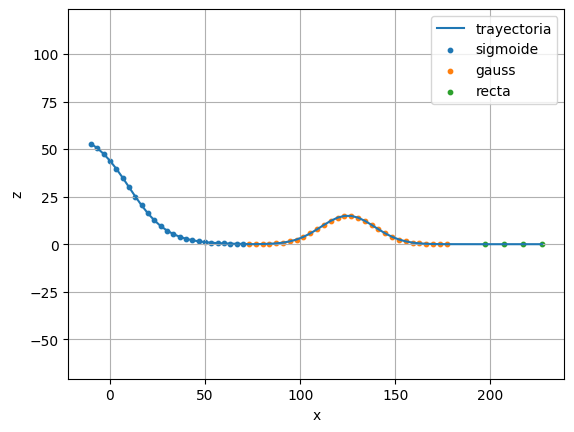

In [97]:
# ---------- 1) Descenso (sigmoide) ----------
# x(u) = x0 + u ; z(u) = z0 + A/(1+e^{m u})
x0, z0, A, m = 10, 0, 60, 0.1
u1 = np.linspace(-20, 60, 25)
seg1 = CV.curva3d("s", u1, A=A, C=[x0, 0, z0], paso=0, plano="xz", args=[m])

'''
# ---------- 2) Loop (clotoide simétrica) ----------
# en tu script se usa tipo "l" para hacer el looping simétrico automáticamente
x0, z0, A = 50, 0, 35
u2 = np.linspace(0, np.sqrt(np.pi), 10)
seg2 = CV.curva3d("l", u2, A=A, C=[x0, 0, z0], paso=0, plano="xz", args=[0])
'''
# ---------- 3) Colina (gaussiana) ----------
# x(u) = x0 + u ; z(u) = z0 + A exp(-(u/s)^2)
x0, z0, A, s = 125, 0, 15, 20
u3 = np.linspace(-52, 52, 30)
seg3 = CV.curva3d("g", u3, A=A, C=[x0, 0, z0], paso=0, plano="xz", args=[s])

# ---------- 4) Recta final ----------
# aquí la hago manual (x lineal, z constante)
x0, z0 = 197, 0
u4 = np.linspace(0, 30, 4)
x4 = x0 + u4
z4 = z0 + 0*u4
y4 = 0*u4
seg4 = np.vstack([x4, y4, z4])

# ---------- concatenación ----------
tray = np.hstack([seg1, seg3, seg4])  # shape (3, N)
x, y, z = tray[0], tray[1], tray[2]

# ---------- plot XZ ----------
plt.figure()
plt.plot(x, z, '-', label="trayectoria")
plt.scatter(seg1[0], seg1[2], s=10, label="sigmoide")
plt.scatter(seg3[0], seg3[2], s=10, label="gauss")
plt.scatter(seg4[0], seg4[2], s=10, label="recta")
plt.xlabel("x")
plt.ylabel("z")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()


Interpolando 59 puntos con B-spline...
Rango x: [-10.0, 227.0] m
Rango z: [0.0, 52.8] m
Longitud de la curva: 265.92 m


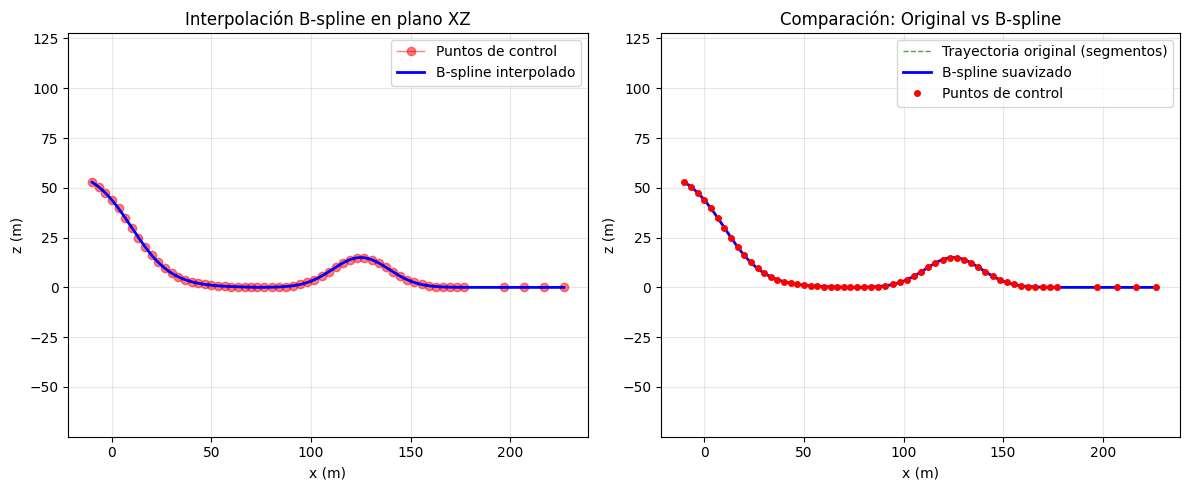


Parámetros u asociados a los 59 puntos de control:
u_min = 0.0000, u_max = 1.0000
Curva parametrizada en u ∈ [0, 1]
Grado del B-spline: k=3 (cúbico)


In [98]:
# ============================================================
# INTERPOLACIÓN CON B-SPLINE USANDO FUNCIÓN DE LA CELDA 2
# ============================================================

# 1) Extraer puntos de control de la trayectoria de la celda anterior
# tray tiene shape (3, N) con [x, y, z]
# Necesitamos (N, 2) con columnas [x, z] para spline_xz
puntos_xz = tray[[0, 2], :].T  # Tomar filas x y z, transponer a (N, 2)

print(f"Interpolando {len(puntos_xz)} puntos con B-spline...")
print(f"Rango x: [{puntos_xz[:, 0].min():.1f}, {puntos_xz[:, 0].max():.1f}] m")
print(f"Rango z: [{puntos_xz[:, 1].min():.1f}, {puntos_xz[:, 1].max():.1f}] m")

# 2) Crear B-spline usando la función de la celda 2
curva_bspline, u_pts = spline_xz(puntos_xz, s=0.0, k=3)

# 3) Evaluar la curva en puntos finos para visualización
u_fino = np.linspace(0, 1, 400)
xyz_fino = curva_bspline(u_fino)
x_fino = xyz_fino[:, 0]
y_fino = xyz_fino[:, 1]
z_fino = xyz_fino[:, 2]

# 4) Calcular longitud de la curva
dxyz = np.diff(xyz_fino, axis=0)
longitud = np.sum(np.linalg.norm(dxyz, axis=1))
print(f"Longitud de la curva: {longitud:.2f} m")

# 5) Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Curva en el plano XZ
ax = axs[0]
ax.plot(puntos_xz[:, 0], puntos_xz[:, 1], 'ro-', markersize=6, linewidth=1, alpha=0.5, label='Puntos de control')
ax.plot(x_fino, z_fino, 'b-', linewidth=2, label='B-spline interpolado')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Interpolación B-spline en plano XZ')
ax.grid(True, alpha=0.3)
ax.axis('equal')
ax.legend()

# Plot 2: Comparación con trayectoria original
ax = axs[1]
ax.plot(x, z, 'g--', linewidth=1, alpha=0.7, label='Trayectoria original (segmentos)')
ax.plot(x_fino, z_fino, 'b-', linewidth=2, label='B-spline suavizado')
ax.plot(puntos_xz[:, 0], puntos_xz[:, 1], 'ro', markersize=4, label='Puntos de control')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Comparación: Original vs B-spline')
ax.grid(True, alpha=0.3)
ax.axis('equal')
ax.legend()

plt.tight_layout()
plt.show()

# 6) Información adicional
print(f"\nParámetros u asociados a los {len(u_pts)} puntos de control:")
print(f"u_min = {u_pts.min():.4f}, u_max = {u_pts.max():.4f}")
print(f"Curva parametrizada en u ∈ [0, 1]")
print(f"Grado del B-spline: k=3 (cúbico)")


El mejor método es Radau copn 105 pasos y un error medio de 5.5*10-6


Generando gráfica...


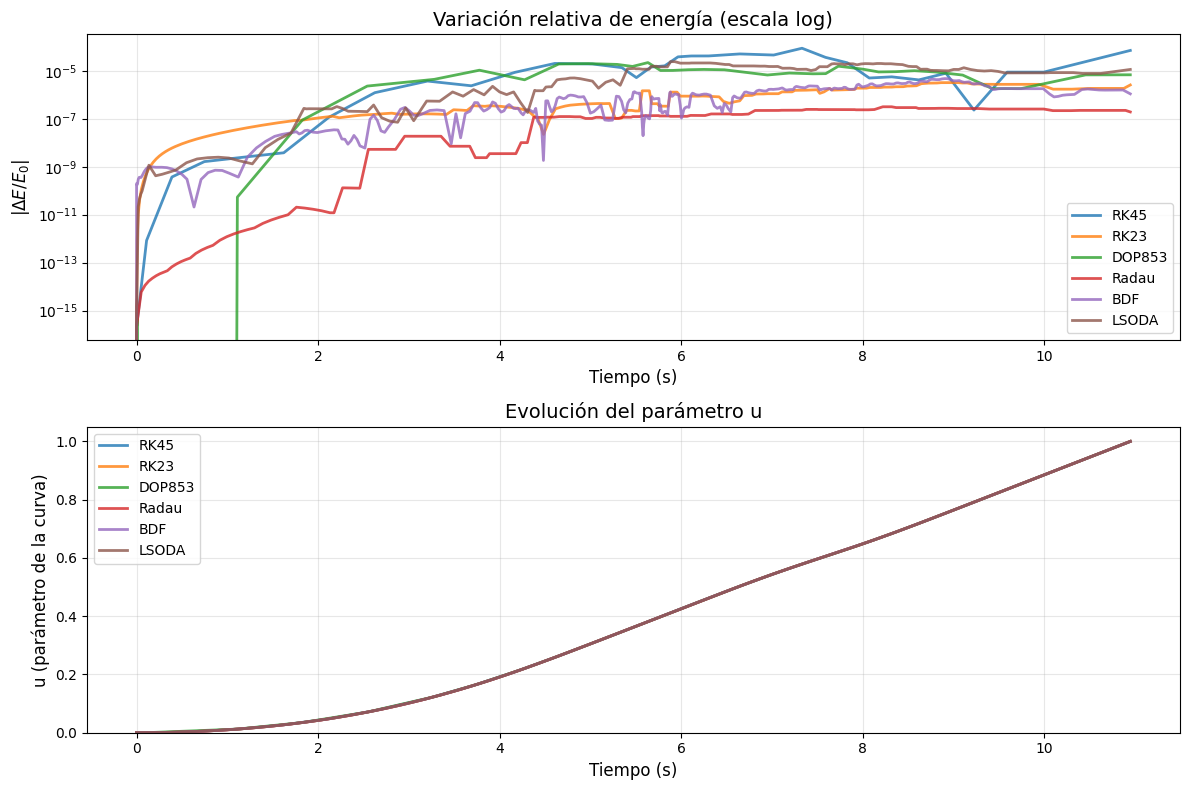


COMPARACIÓN DE MÉTODOS NUMÉRICOS (SISTEMA CONSERVATIVO)
Curva: B-spline interpolado de la trayectoria de montaña rusa
Tolerancias: rtol=1e-06, atol=1e-09
Método   Status     Pasos   t_final   u_final       ΔE_min       ΔE_max     ΔE_final
----------------------------------------------------------------------------------------------------
RK45     OK            35    10.948   1.00000 -8.8681e-05 +1.4508e-05 -7.1775e-05
RK23     OK           209    10.947   1.00000 -3.2593e-06 +1.3009e-06 -2.6019e-06
DOP853   OK            37    10.947   1.00000 -4.3858e-16 +2.2348e-05 +6.9084e-06
Radau    OK           208    10.947   1.00000 -3.5331e-09 +3.1937e-07 +1.9451e-07
BDF      OK           383    10.947   1.00000 -1.3589e-06 +4.7905e-06 +1.1066e-06
LSODA    OK           234    10.948   1.00000 -2.4561e-05 +1.2301e-05 -1.1533e-05


In [ ]:
# ============================================================
# FUNCIÓN WRAPPER SEGURA PARA EDO
# ============================================================

def edofun_mr_wrapper(t, y, posyder, coefRoz, coefVis, grav):
    """
    Wrapper seguro que evita evaluaciones fuera del dominio [0,1]
    """
    u, v = y
    
    # CRÍTICO: Proyectar u al dominio válido
    u = np.clip(u, 0.0, 1.0)
    
    try:
        # Importar funciones necesarias
        from pkgmrusa import fuerzaNormal, aceleratg
        
        fuerzaN, baseLocal, ctes = fuerzaNormal(u, v, posyder, grav)
        
        # Evitar división por cero
        if abs(ctes[0]) < 1e-12:
            return [0.0, 0.0]
        du = v / ctes[0]
        dv = aceleratg(v, baseLocal, coefRoz, coefVis, fuerzaN, grav)
        # Verificar que no hay NaN o Inf
        if not (np.isfinite(du) and np.isfinite(dv)):
            return [0.0, 0.0]
        
        return [du, dv]
        
    except:
        return [0.0, 0.0]


# ============================================================
# EVENTOS SEGUROS
# ============================================================

def finalVia_wrapper(t, y, posyder, coefRoz, coefVis, grav):
    """Evento: llegada al final de la vía"""
    return y[0] - 1.0

finalVia_wrapper.terminal = True
finalVia_wrapper.direction = 0


def paradaVagon_wrapper(t, y, posyder, coefRoz, coefVis, grav):
    """Evento: parada del vagón"""
    return y[1]

paradaVagon_wrapper.terminal = True
paradaVagon_wrapper.direction = -1


# ============================================================
# CÓDIGO PRINCIPAL (REEMPLAZO DIRECTO)
# ============================================================

curva = curva_bspline  # Tu curva ya existente
derivs = trayec_der(curva)

# Parámetros físicos (conservativo)
g = 9.81
coefRoz = 0.0
coefVis = 0.0
y0 = [0.0, 0.0]  # u(0)=0, v(0)=0

t_end =40.0  # Se deja esta para evitar problemas

# 5) Tolerancias comunes
rtol = 1e-6
atol = 1e-9

metodos = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]
resultados = {}


for m in metodos:
    
    try:
        # Configuración base
        solver_config = {
            "method": m,
            "rtol": rtol,
            "atol": atol,
            "dense_output": True,
            "events": [finalVia_wrapper, paradaVagon_wrapper]
        }
        
        # SOLUCIÓN CLAVE: Para métodos implícitos (Radau, BDF)
        # necesitamos limitar el paso máximo y usar tolerancias más estrictas
        if m in ["Radau", "BDF"]:
            solver_config["max_step"] = 0.1  # Limitar paso máximo
            solver_config["rtol"] = rtol / 10  # Tolerancia más estricta
            solver_config["atol"] = atol / 10
        
        # Resolver usando la función wrapper segura
        sol = solve_ivp(
            edofun_mr_wrapper,
            t_span=(0.0, t_end),
            y0=y0,
            args=(derivs, coefRoz, coefVis, g),
            **solver_config
        )
        
        if not sol.success:
            print(f"FALLÓ: {sol.message}")
            resultados[m] = {"ok": False, "error": sol.message}
            continue
        
        # Extraer solución
        t = sol.t
        u = sol.y[0]
        v = sol.y[1]
        
        # FILTRADO ROBUSTO: Eliminar puntos inválidos
        # Esto es crucial para Radau y BDF
        mask = (np.isfinite(u) & 
                np.isfinite(v) & 
                (u >= 0.0) & 
                (u <= 1.0) &
                np.isfinite(t))
        
        if not np.any(mask):
            print("FALLÓ: Sin puntos válidos")
            resultados[m] = {"ok": False, "error": "No valid points"}
            continue
        
        t = t[mask]
        u = u[mask]
        v = v[mask]
        
        # Calcular energía de forma segura
        E = []
        for ui, vi in zip(u, v):
            try:
                Ei = energia(ui, vi, derivs[0], grav=g)
                if np.isfinite(Ei):
                    E.append(Ei)
                else:
                    E.append(np.nan)
            except:
                E.append(np.nan)
        
        E = np.array(E)
        
        # Filtrar puntos con energía válida
        mask_E = np.isfinite(E)
        
        if not np.any(mask_E):
            print("FALLÓ: Energía inválida")
            resultados[m] = {"ok": False, "error": "Invalid energy"}
            continue
        
        # Aplicar máscara
        t = t[mask_E]
        u = u[mask_E]
        v = v[mask_E]
        E = E[mask_E]
        
        # Verificar que tengamos puntos suficientes
        if len(t) < 5:
            print(f"FALLÓ: Solo {len(t)} puntos válidos")
            resultados[m] = {"ok": False, "error": f"Only {len(t)} points"}
            continue
        
        # Calcular variación de energía
        E0 = E[0]
        
        if abs(E0) < 1e-10:
            print("FALLÓ: E0 ≈ 0")
            resultados[m] = {"ok": False, "error": "E0 too small"}
            continue
        
        dE = (E - E0) / E0
        dEabs = np.abs(dE)
        
        # Guardar resultados
        resultados[m] = {
            "ok": True,
            "pasos": len(t) - 1,
            "t": t,
            "u": u,
            "v": v,
            "E": E,
            "dE": dE,
            "dEabs": dEabs,
            "dE_min": float(np.min(dE)),
            "dE_max": float(np.max(dE)),
            "dE_mean": float(np.mean(dE)),
            "dE_std": float(np.std(dE)),
            "dE_final": float(dE[-1]),
            "t_final": float(t[-1]),
            "u_final": float(u[-1])
        }
        
    except Exception as e:
        print(f"EXCEPCIÓN: {type(e).__name__}")
        resultados[m] = {"ok": False, "error": f"{type(e).__name__}: {str(e)[:50]}"}

# 7) Visualización: Variación de energía (escala log)
print("\n" + "="*80)
print("Generando gráfica...")
print("="*80)

metodos_ok = [m for m in metodos if resultados[m]["ok"]]

if len(metodos_ok) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Gráfica 1: Energía (escala log)
    ax = axes[0]
    for m in metodos_ok:
        ax.semilogy(resultados[m]["t"], resultados[m]["dEabs"], 
                   label=m, linewidth=2, alpha=0.8)
    ax.set_xlabel("Tiempo (s)", fontsize=12)
    ax.set_ylabel(r"$|\Delta E / E_0|$", fontsize=12)
    ax.set_title("Variación relativa de energía (escala log)", fontsize=14)
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(fontsize=10, loc='best')
    
    # Gráfica 2: Parámetro u(t)
    ax = axes[1]
    for m in metodos_ok:
        ax.plot(resultados[m]["t"], resultados[m]["u"], 
               label=m, linewidth=2, alpha=0.8)
    ax.set_xlabel("Tiempo (s)", fontsize=12)
    ax.set_ylabel("u (parámetro de la curva)", fontsize=12)
    ax.set_title("Evolución del parámetro u", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ No hay métodos exitosos para graficar")

# 8) Tabla resumen estadístico
print("\n" + "="*100)
print("COMPARACIÓN DE MÉTODOS NUMÉRICOS (SISTEMA CONSERVATIVO)")
print("Curva: B-spline interpolado de la trayectoria de montaña rusa")
print(f"Tolerancias: rtol={rtol:.0e}, atol={atol:.0e}")
print("="*100)
print(f"{'Método':<8} {'Status':<8} {'Pasos':>7} {'t_final':>9} {'u_final':>9} "
      f"{'ΔE_min':>12} {'ΔE_max':>12} {'ΔE_final':>12}")
print("-"*100)

for m in metodos:
    if resultados[m]["ok"]:
        r = resultados[m]
        print(f"{m:<8} {'OK':<8} {r['pasos']:>7d} {r['t_final']:>9.3f} "
              f"{r['u_final']:>9.5f} {r['dE_min']:>+.4e} {r['dE_max']:>+.4e} "
              f"{r['dE_final']:>+.4e}")
    else:
        error = resultados[m]['error']
        if len(error) > 40:
            error = error[:37] + "..."
        print(f"{m:<8} {'FALLÓ':<8} {'-':>7s} {'-':>9s} {'-':>9s} "
              f"{'':>12s} {'':>12s} {error}")

print("="*100)



Resolviendo con método Radau...
✓ Solución obtenida exitosamente
  Número de pasos: 113
  Tiempo final: 10.58 s
  Posición final: u = 1.0000
  Velocidad final: v = 32.26 m/s
  ✓ Evento 'finalVia' activado en t = 10.58 s

Forma de posicion: (500, 3)
Forma de x: (500,), Forma de y: (500,)
Forma de time: (500,), Forma de u: (500,), Forma de v: (500,)
Calculando fuerzas, energías y aceleraciones...
✓ Cálculos completados


C:\Users\miguel\AppData\Local\Temp\ipykernel_28752\2440203170.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


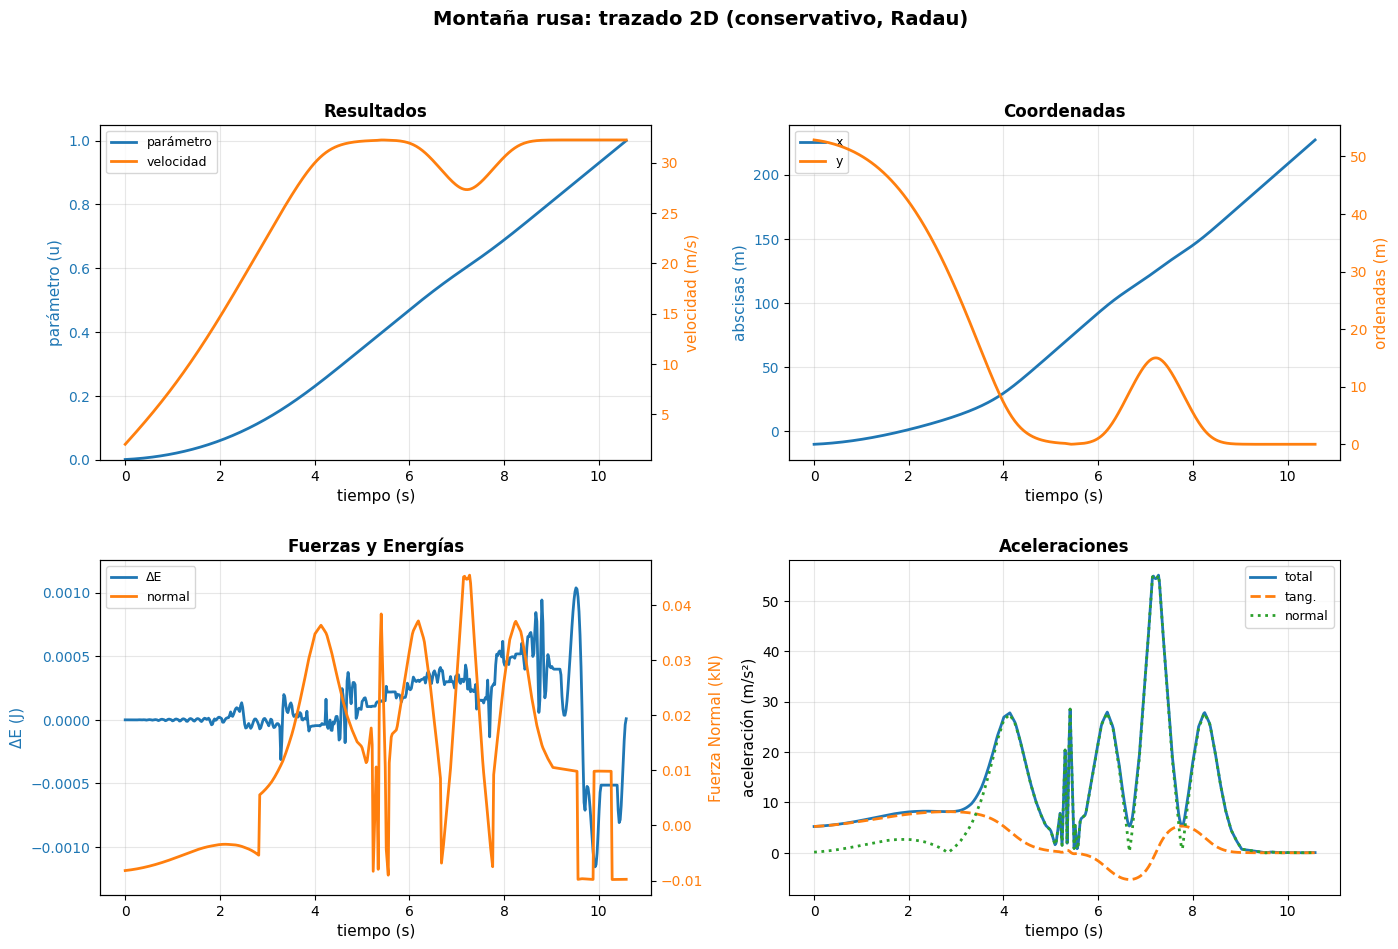


ESTADÍSTICAS DEL RECORRIDO
Tiempo total:           10.58 s
Velocidad máxima:       32.26 m/s (116.15 km/h)
Velocidad media:        25.12 m/s (90.42 km/h)
Aceleración máxima:     55.13 m/s² (5.62 g)
Fuerza normal máxima:   45.37 N/kg (4.62 g)
Energía inicial:        520.44 J/kg
Energía final:          520.44 J/kg
Máx variación energía:  0.0002 % (conservativo)


In [100]:
# -*- coding: utf-8 -*-
# -*- coding: utf-8 -*-
# ============================================================================
# PARÁMETROS DEL PROBLEMA
# ============================================================================

# Parámetros físicos
g = 9.81              # Aceleración gravitatoria (m/s²)
mu = 0.0            # Coeficiente de fricción
ca = 0.0              # Coeficiente de resistencia aerodinámica
Sf = 2.0              # Superficie frontal (m²)
rho_aire = 1.225      # Densidad del aire (kg/m³)
masa = 800.0          # Masa del vagón (kg)

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

# Condiciones iniciales
y0 = [0.0, 2.0]   # [u(0), v(0)] = [posición inicial, velocidad inicial]

t_end = 40.0

# Parámetros del solver
metodo = 'Radau'   # Método numérico: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
rtol = 1e-6       # Tolerancia relativa
atol = 1e-9       # Tolerancia absoluta

# ============================================================================
# RESOLVER LA EDO
# ============================================================================

print(f"\nResolviendo con método {metodo}...")

sol = solve_ivp(
    edofun_mr_wrapper,
    t_span=(0.0, t_end),
    y0=y0,
    args=(derivs, coefRoz, coefVis, g),
    method=metodo,
    events=[finalVia_wrapper, paradaVagon_wrapper],
    dense_output=True,  # Necesario para interpolación
    rtol=rtol,
    atol=atol
)

# Verificar si la solución fue exitosa
if not sol.success:
    raise RuntimeError(f"El solver falló: {sol.message}")

print(f"✓ Solución obtenida exitosamente")
print(f"  Número de pasos: {len(sol.t)}")
print(f"  Tiempo final: {sol.t[-1]:.2f} s")
print(f"  Posición final: u = {sol.y[0][-1]:.4f}")
print(f"  Velocidad final: v = {sol.y[1][-1]:.2f} m/s")

# Verificar eventos
if sol.t_events[0].size > 0:
    print(f"  ✓ Evento 'finalVia' activado en t = {sol.t_events[0][0]:.2f} s")
if sol.t_events[1].size > 0:
    print(f"  ⚠ Evento 'paradaVagon' activado en t = {sol.t_events[1][0]:.2f} s")

# ============================================================================
# PREPARAR DATOS PARA GRAFICADO
# ============================================================================

# Parámetros para los gráficos
n_puntos = 500  # Número de puntos para suavizar las curvas

titulo = f"Montaña rusa: trazado 2D (conservativo, {metodo})"

# ============================================================================
# CALCULAR DATOS PARA LOS GRÁFICOS
# ============================================================================

# Generar puntos de tiempo uniformes
time = np.linspace(0, sol.t[-1], n_puntos)

# Obtener solución interpolada (requiere dense_output=True en solve_ivp)
data = sol.sol(time)
u = data[0]  # parámetro
v = data[1]  # velocidad

# Calcular posición espacial
posicion = curva_bspline(u)

# Verificar la forma del array y extraer correctamente
print(f"\nForma de posicion: {posicion.shape}")

# Extraer coordenadas correctamente según la forma del array
if posicion.ndim == 1:
    # Si es un array 1D (un solo punto), replicar
    x = np.full(n_puntos, posicion[0])
    y = np.full(n_puntos, posicion[2])
elif posicion.shape[0] == 3:
    # Forma (3, n_puntos) - LO MÁS COMÚN
    x = posicion[0, :]  # primera fila = coordenada x
    y = posicion[2, :]  # tercera fila = coordenada z (altura)
elif posicion.shape[1] == 3:
    # Forma (n_puntos, 3) - alternativa
    x = posicion[:, 0]
    y = posicion[:, 2]
else:
    raise ValueError(f"Forma de posicion no esperada: {posicion.shape}")

print(f"Forma de x: {x.shape}, Forma de y: {y.shape}")
print(f"Forma de time: {time.shape}, Forma de u: {u.shape}, Forma de v: {v.shape}")

# Inicializar arrays para fuerzas, energías y aceleraciones
E_total = np.zeros(n_puntos)
F_normal = np.zeros(n_puntos)
a_total = np.zeros(n_puntos)
a_tang = np.zeros(n_puntos)
a_normal = np.zeros(n_puntos)

# Calcular para cada punto
print("Calculando fuerzas, energías y aceleraciones...")
for i in range(n_puntos):
    try:
        # Energía total por unidad de masa
        E_total[i] = energia(u[i], v[i], derivs[0], grav=g)
        
        # Fuerza normal por unidad de masa
        fuerzaN, baseLocal, ctes = fuerzaNormal(u[i], v[i], derivs, grav=g)
        F_normal[i] = fuerzaN
        
        # Aceleraciones
        a_tot, a_tg, a_nr = aceleracion(v[i], baseLocal, coefRoz, coefVis, 
                                         fuerzaN, ctes[1], grav=g)
        a_total[i] = a_tot
        a_tang[i] = a_tg
        a_normal[i] = a_nr
    except Exception as e:
        print(f"Error en punto {i}: {e}")
        # Usar valores del punto anterior o cero
        if i > 0:
            E_total[i] = E_total[i-1]
            F_normal[i] = F_normal[i-1]
            a_total[i] = a_total[i-1]
            a_tang[i] = a_tang[i-1]
            a_normal[i] = a_normal[i-1]

print("✓ Cálculos completados")

# ============================================================================
# CREAR FIGURA CON 4 SUBPLOTS
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ============================================================================
# SUBPLOT 1: RESULTADOS (parámetro u y velocidad v vs tiempo)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

# Eje izquierdo: parámetro u
color_u = 'tab:blue'
ax1.set_xlabel('tiempo (s)', fontsize=11)
ax1.set_ylabel('parámetro (u)', color=color_u, fontsize=11)
line1 = ax1.plot(time, u, color=color_u, linewidth=2, label='parámetro')
ax1.tick_params(axis='y', labelcolor=color_u)
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Eje derecho: velocidad v
ax1_twin = ax1.twinx()
color_v = 'tab:orange'
ax1_twin.set_ylabel('velocidad (m/s)', color=color_v, fontsize=11)
line2 = ax1_twin.plot(time, v, color=color_v, linewidth=2, label='velocidad')
ax1_twin.tick_params(axis='y', labelcolor=color_v)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', fontsize=9)

ax1.set_title('Resultados', fontsize=12, fontweight='bold')

# ============================================================================
# SUBPLOT 2: COORDENADAS (x e y vs tiempo)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])

# Eje izquierdo: abscisas x
color_x = 'tab:blue'
ax2.set_xlabel('tiempo (s)', fontsize=11)
ax2.set_ylabel('abscisas (m)', color=color_x, fontsize=11)
line1 = ax2.plot(time, x, color=color_x, linewidth=2, label='x')
ax2.tick_params(axis='y', labelcolor=color_x)
ax2.grid(True, alpha=0.3)

# Eje derecho: ordenadas y
ax2_twin = ax2.twinx()
color_y = 'tab:orange'
ax2_twin.set_ylabel('ordenadas (m)', color=color_y, fontsize=11)
line2 = ax2_twin.plot(time, y, color=color_y, linewidth=2, label='y')
ax2_twin.tick_params(axis='y', labelcolor=color_y)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best', fontsize=9)

ax2.set_title('Coordenadas', fontsize=12, fontweight='bold')

# ============================================================================
# SUBPLOT 3: FUERZAS Y ENERGÍAS (mostrando pérdida de energía)
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])

# --- Energía: mostrar variación respecto al inicio en Joules ---
E0_kJ = E_total[0] / 1000.0                # energía inicial (kJ)
dE_J  = (E_total / 1000.0 - E0_kJ) * 1000  # ΔE en Joules (porque 1 kJ = 1000 J)

color_E = 'tab:blue'
ax3.set_xlabel('tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J)', color=color_E, fontsize=11)
line1 = ax3.plot(time, dE_J, color=color_E, linewidth=2, label='ΔE')
ax3.tick_params(axis='y', labelcolor=color_E)
ax3.grid(True, alpha=0.3)

# --- Escala: ajusta automáticamente con margen para que se aprecie la pérdida ---
dE_min = float(min(dE_J))
dE_max = float(max(dE_J))
span = dE_max - dE_min
if span == 0:
    span = 1.0  # evita división por cero si fuera constante

margin = 0.10 * span  # 10% de margen
ax3.set_ylim(dE_min - margin, dE_max + margin)

# --- Fuerza normal en el eje derecho (kN) ---
ax3_twin = ax3.twinx()
color_F = 'tab:orange'
ax3_twin.set_ylabel('Fuerza Normal (kN)', color=color_F, fontsize=11)
line2 = ax3_twin.plot(time, F_normal/1000.0, color=color_F, linewidth=2, label='normal')
ax3_twin.tick_params(axis='y', labelcolor=color_F)

# --- Leyenda combinada ---
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='best', fontsize=9)

ax3.set_title('Fuerzas y Energías', fontsize=12, fontweight='bold')


# ============================================================================
# SUBPLOT 4: ACELERACIONES
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])

ax4.set_xlabel('tiempo (s)', fontsize=11)
ax4.set_ylabel('aceleración (m/s²)', fontsize=11)

ax4.plot(time, a_total, linewidth=2, label='total', color='tab:blue')
ax4.plot(time, a_tang, linewidth=2, linestyle='--', label='tang.', 
         color='tab:orange')
ax4.plot(time, a_normal, linewidth=2, linestyle=':', label='normal', 
         color='tab:green')

ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)
ax4.set_title('Aceleraciones', fontsize=12, fontweight='bold')

# ============================================================================
# TÍTULO GENERAL Y MOSTRAR
# ============================================================================
fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# ============================================================================
# ESTADÍSTICAS ADICIONALES (OPCIONAL)
# ============================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS DEL RECORRIDO")
print("="*70)
print(f"Tiempo total:           {sol.t[-1]:.2f} s")
print(f"Velocidad máxima:       {np.max(v):.2f} m/s ({np.max(v)*3.6:.2f} km/h)")
print(f"Velocidad media:        {np.mean(v):.2f} m/s ({np.mean(v)*3.6:.2f} km/h)")
print(f"Aceleración máxima:     {np.max(a_total):.2f} m/s² ({np.max(a_total)/g:.2f} g)")
print(f"Fuerza normal máxima:   {np.max(F_normal):.2f} N/kg ({np.max(F_normal)/g:.2f} g)")
print(f"Energía inicial:        {E_total[0]:.2f} J/kg")
print(f"Energía final:          {E_total[-1]:.2f} J/kg")

if coefRoz > 0 or coefVis > 0:
    perdida = (E_total[0] - E_total[-1]) / E_total[0] * 100
    print(f"Pérdida de energía:     {perdida:.2f} %")
else:
    # Sistema conservativo - verificar conservación
    dE = np.abs(E_total - E_total[0]) / E_total[0]
    conservacion = np.max(dE) * 100
    print(f"Máx variación energía:  {conservacion:.4f} % (conservativo)")

print("="*70)


Resolviendo con método Radau...
✓ Solución obtenida exitosamente
  Número de pasos: 144
  Tiempo final: 10.92 s
  Posición final: u = 1.0000
  Velocidad final: v = 30.12 m/s
  ✓ Evento 'finalVia' activado en t = 10.92 s

Forma de posicion: (500, 3)
Forma de x: (500,), Forma de y: (500,)
Forma de time: (500,), Forma de u: (500,), Forma de v: (500,)
Calculando fuerzas, energías y aceleraciones...
✓ Cálculos completados


C:\Users\miguel\AppData\Local\Temp\ipykernel_28752\3417132120.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


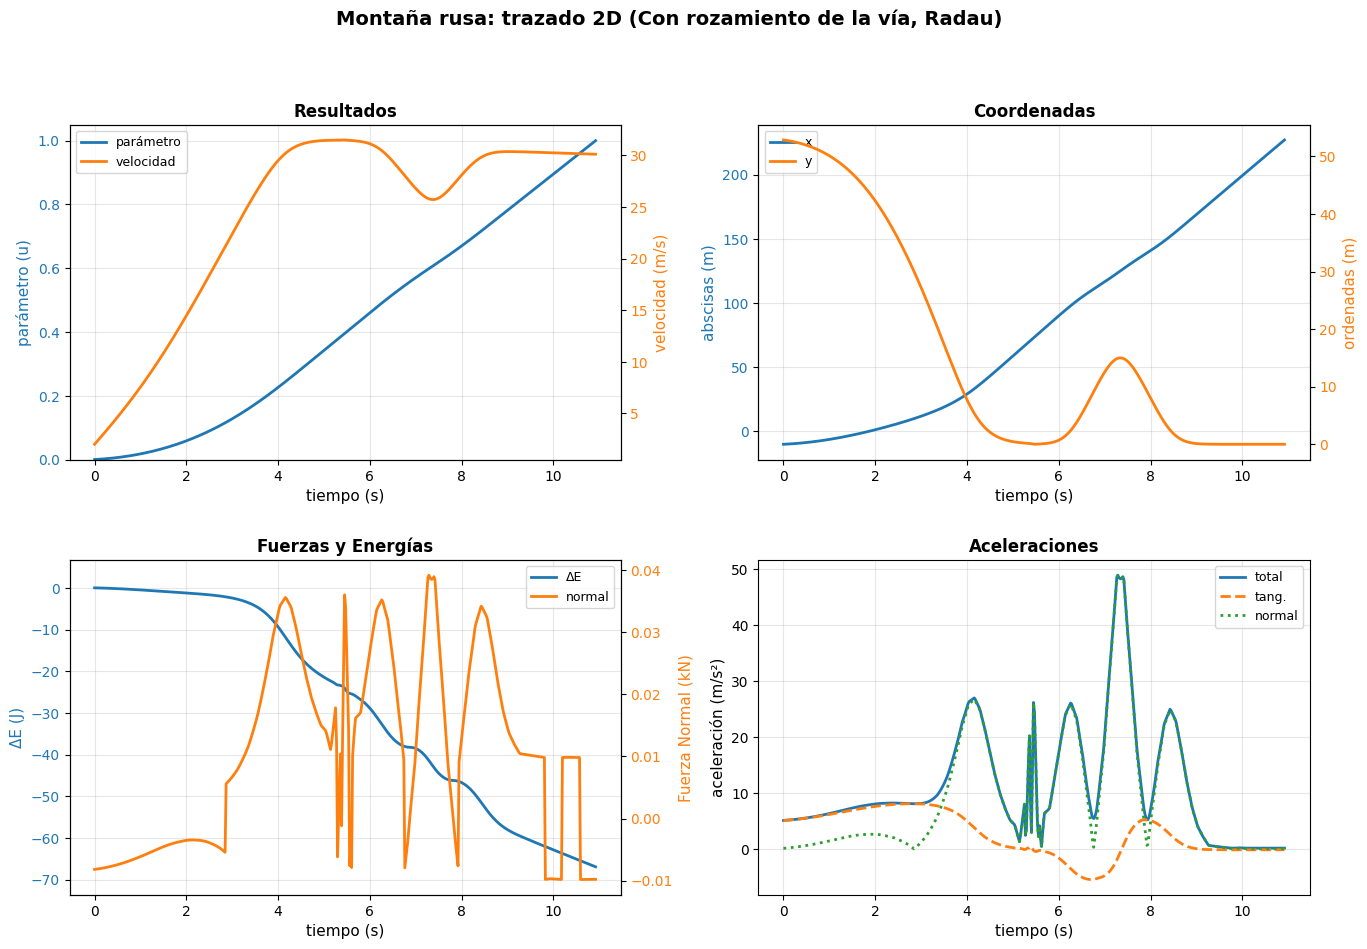


ESTADÍSTICAS DEL RECORRIDO
Tiempo total:           10.92 s
Velocidad máxima:       31.50 m/s (113.41 km/h)
Velocidad media:        24.34 m/s (87.62 km/h)
Aceleración máxima:     48.92 m/s² (4.99 g)
Fuerza normal máxima:   39.14 N/kg (3.99 g)
Energía inicial:        520.44 J/kg
Energía final:          453.50 J/kg
Pérdida de energía:     12.86 %


In [101]:
# -*- coding: utf-8 -*-
# -*- coding: utf-8 -*-
# ============================================================================
# PARÁMETROS DEL PROBLEMA
# ============================================================================

# Parámetros físicos dados
g = 9.81              # Aceleración gravitatoria (m/s²)
mu = 0.015            # Coeficiente de fricción
ca = 0.0              # Coeficiente de resistencia aerodinámica
Sf = 2.0              # Superficie frontal (m²)
rho_aire = 1.225      # Densidad del aire (kg/m³)
v0 = 2.0              # Velocidad inicial (m/s)
masa = 800.0          # Masa del vagón (kg)

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

# Condiciones iniciales
y0 = [0.0, 2.0]   # [u(0), v(0)] = [posición inicial, velocidad inicial]

t_end = 40.0

# Parámetros del solver
metodo = 'Radau'   # Método numérico: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
rtol = 1e-6       # Tolerancia relativa
atol = 1e-9       # Tolerancia absoluta

# ============================================================================
# RESOLVER LA EDO
# ============================================================================

print(f"\nResolviendo con método {metodo}...")

sol = solve_ivp(
    edofun_mr_wrapper,
    t_span=(0.0, t_end),
    y0=y0,
    args=(derivs, coefRoz, coefVis, g),
    method=metodo,
    events=[finalVia_wrapper, paradaVagon_wrapper],
    dense_output=True,  # Necesario para interpolación
    rtol=rtol,
    atol=atol
)

# Verificar si la solución fue exitosa
if not sol.success:
    raise RuntimeError(f"El solver falló: {sol.message}")

print(f"✓ Solución obtenida exitosamente")
print(f"  Número de pasos: {len(sol.t)}")
print(f"  Tiempo final: {sol.t[-1]:.2f} s")
print(f"  Posición final: u = {sol.y[0][-1]:.4f}")
print(f"  Velocidad final: v = {sol.y[1][-1]:.2f} m/s")

# Verificar eventos
if sol.t_events[0].size > 0:
    print(f"  ✓ Evento 'finalVia' activado en t = {sol.t_events[0][0]:.2f} s")
if sol.t_events[1].size > 0:
    print(f"  ⚠ Evento 'paradaVagon' activado en t = {sol.t_events[1][0]:.2f} s")

# ============================================================================
# PREPARAR DATOS PARA GRAFICADO
# ============================================================================

# Parámetros para los gráficos
n_puntos = 500  # Número de puntos para suavizar las curvas

titulo = f"Montaña rusa: trazado 2D (Con rozamiento de la vía, {metodo})"

# ============================================================================
# CALCULAR DATOS PARA LOS GRÁFICOS
# ============================================================================

# Generar puntos de tiempo uniformes
time = np.linspace(0, sol.t[-1], n_puntos)

# Obtener solución interpolada (requiere dense_output=True en solve_ivp)
data = sol.sol(time)
u = data[0]  # parámetro
v = data[1]  # velocidad

# Calcular posición espacial
posicion = curva_bspline(u)

# Verificar la forma del array y extraer correctamente
print(f"\nForma de posicion: {posicion.shape}")

# Extraer coordenadas correctamente según la forma del array
if posicion.ndim == 1:
    # Si es un array 1D (un solo punto), replicar
    x = np.full(n_puntos, posicion[0])
    y = np.full(n_puntos, posicion[2])
elif posicion.shape[0] == 3:
    # Forma (3, n_puntos) - LO MÁS COMÚN
    x = posicion[0, :]  # primera fila = coordenada x
    y = posicion[2, :]  # tercera fila = coordenada z (altura)
elif posicion.shape[1] == 3:
    # Forma (n_puntos, 3) - alternativa
    x = posicion[:, 0]
    y = posicion[:, 2]
else:
    raise ValueError(f"Forma de posicion no esperada: {posicion.shape}")

print(f"Forma de x: {x.shape}, Forma de y: {y.shape}")
print(f"Forma de time: {time.shape}, Forma de u: {u.shape}, Forma de v: {v.shape}")

# Inicializar arrays para fuerzas, energías y aceleraciones
E_total = np.zeros(n_puntos)
F_normal = np.zeros(n_puntos)
a_total = np.zeros(n_puntos)
a_tang = np.zeros(n_puntos)
a_normal = np.zeros(n_puntos)

# Calcular para cada punto
print("Calculando fuerzas, energías y aceleraciones...")
for i in range(n_puntos):
    try:
        # Energía total por unidad de masa
        E_total[i] = energia(u[i], v[i], derivs[0], grav=g)
        
        # Fuerza normal por unidad de masa
        fuerzaN, baseLocal, ctes = fuerzaNormal(u[i], v[i], derivs, grav=g)
        F_normal[i] = fuerzaN
        
        # Aceleraciones
        a_tot, a_tg, a_nr = aceleracion(v[i], baseLocal, coefRoz, coefVis, 
                                         fuerzaN, ctes[1], grav=g)
        a_total[i] = a_tot
        a_tang[i] = a_tg
        a_normal[i] = a_nr
    except Exception as e:
        print(f"Error en punto {i}: {e}")
        # Usar valores del punto anterior o cero
        if i > 0:
            E_total[i] = E_total[i-1]
            F_normal[i] = F_normal[i-1]
            a_total[i] = a_total[i-1]
            a_tang[i] = a_tang[i-1]
            a_normal[i] = a_normal[i-1]

print("✓ Cálculos completados")

# ============================================================================
# CREAR FIGURA CON 4 SUBPLOTS
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ============================================================================
# SUBPLOT 1: RESULTADOS (parámetro u y velocidad v vs tiempo)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

# Eje izquierdo: parámetro u
color_u = 'tab:blue'
ax1.set_xlabel('tiempo (s)', fontsize=11)
ax1.set_ylabel('parámetro (u)', color=color_u, fontsize=11)
line1 = ax1.plot(time, u, color=color_u, linewidth=2, label='parámetro')
ax1.tick_params(axis='y', labelcolor=color_u)
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Eje derecho: velocidad v
ax1_twin = ax1.twinx()
color_v = 'tab:orange'
ax1_twin.set_ylabel('velocidad (m/s)', color=color_v, fontsize=11)
line2 = ax1_twin.plot(time, v, color=color_v, linewidth=2, label='velocidad')
ax1_twin.tick_params(axis='y', labelcolor=color_v)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', fontsize=9)

ax1.set_title('Resultados', fontsize=12, fontweight='bold')

# ============================================================================
# SUBPLOT 2: COORDENADAS (x e y vs tiempo)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])

# Eje izquierdo: abscisas x
color_x = 'tab:blue'
ax2.set_xlabel('tiempo (s)', fontsize=11)
ax2.set_ylabel('abscisas (m)', color=color_x, fontsize=11)
line1 = ax2.plot(time, x, color=color_x, linewidth=2, label='x')
ax2.tick_params(axis='y', labelcolor=color_x)
ax2.grid(True, alpha=0.3)

# Eje derecho: ordenadas y
ax2_twin = ax2.twinx()
color_y = 'tab:orange'
ax2_twin.set_ylabel('ordenadas (m)', color=color_y, fontsize=11)
line2 = ax2_twin.plot(time, y, color=color_y, linewidth=2, label='y')
ax2_twin.tick_params(axis='y', labelcolor=color_y)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best', fontsize=9)

ax2.set_title('Coordenadas', fontsize=12, fontweight='bold')

# ============================================================================
# SUBPLOT 3: FUERZAS Y ENERGÍAS (mostrando pérdida de energía)
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])

# --- Energía: mostrar variación respecto al inicio en Joules ---
E0_kJ = E_total[0] / 1000.0                # energía inicial (kJ)
dE_J  = (E_total / 1000.0 - E0_kJ) * 1000  # ΔE en Joules (porque 1 kJ = 1000 J)

color_E = 'tab:blue'
ax3.set_xlabel('tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J)', color=color_E, fontsize=11)
line1 = ax3.plot(time, dE_J, color=color_E, linewidth=2, label='ΔE')
ax3.tick_params(axis='y', labelcolor=color_E)
ax3.grid(True, alpha=0.3)

# --- Escala: ajusta automáticamente con margen para que se aprecie la pérdida ---
dE_min = float(min(dE_J))
dE_max = float(max(dE_J))
span = dE_max - dE_min
if span == 0:
    span = 1.0  # evita división por cero si fuera constante

margin = 0.10 * span  # 10% de margen
ax3.set_ylim(dE_min - margin, dE_max + margin)

# --- Fuerza normal en el eje derecho (kN) ---
ax3_twin = ax3.twinx()
color_F = 'tab:orange'
ax3_twin.set_ylabel('Fuerza Normal (kN)', color=color_F, fontsize=11)
line2 = ax3_twin.plot(time, F_normal/1000.0, color=color_F, linewidth=2, label='normal')
ax3_twin.tick_params(axis='y', labelcolor=color_F)

# --- Leyenda combinada ---
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='best', fontsize=9)

ax3.set_title('Fuerzas y Energías', fontsize=12, fontweight='bold')


# ============================================================================
# SUBPLOT 4: ACELERACIONES
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])

ax4.set_xlabel('tiempo (s)', fontsize=11)
ax4.set_ylabel('aceleración (m/s²)', fontsize=11)

ax4.plot(time, a_total, linewidth=2, label='total', color='tab:blue')
ax4.plot(time, a_tang, linewidth=2, linestyle='--', label='tang.', 
         color='tab:orange')
ax4.plot(time, a_normal, linewidth=2, linestyle=':', label='normal', 
         color='tab:green')

ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)
ax4.set_title('Aceleraciones', fontsize=12, fontweight='bold')

# ============================================================================
# TÍTULO GENERAL Y MOSTRAR
# ============================================================================
fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# ============================================================================
# ESTADÍSTICAS ADICIONALES (OPCIONAL)
# ============================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS DEL RECORRIDO")
print("="*70)
print(f"Tiempo total:           {sol.t[-1]:.2f} s")
print(f"Velocidad máxima:       {np.max(v):.2f} m/s ({np.max(v)*3.6:.2f} km/h)")
print(f"Velocidad media:        {np.mean(v):.2f} m/s ({np.mean(v)*3.6:.2f} km/h)")
print(f"Aceleración máxima:     {np.max(a_total):.2f} m/s² ({np.max(a_total)/g:.2f} g)")
print(f"Fuerza normal máxima:   {np.max(F_normal):.2f} N/kg ({np.max(F_normal)/g:.2f} g)")
print(f"Energía inicial:        {E_total[0]:.2f} J/kg")
print(f"Energía final:          {E_total[-1]:.2f} J/kg")

if coefRoz > 0 or coefVis > 0:
    perdida = (E_total[0] - E_total[-1]) / E_total[0] * 100
    print(f"Pérdida de energía:     {perdida:.2f} %")
else:
    # Sistema conservativo - verificar conservación
    dE = np.abs(E_total - E_total[0]) / E_total[0]
    conservacion = np.max(dE) * 100
    print(f"Máx variación energía:  {conservacion:.4f} % (conservativo)")
print("="*70)


Resolviendo con método Radau...
✓ Solución obtenida exitosamente
  Número de pasos: 164
  Tiempo final: 11.53 s
  Posición final: u = 1.0000
  Velocidad final: v = 26.31 m/s
  ✓ Evento 'finalVia' activado en t = 11.53 s

Forma de posicion: (500, 3)
Forma de x: (500,), Forma de y: (500,)
Forma de time: (500,), Forma de u: (500,), Forma de v: (500,)
Calculando fuerzas, energías y aceleraciones...
✓ Cálculos completados


C:\Users\miguel\AppData\Local\Temp\ipykernel_28752\1604370692.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


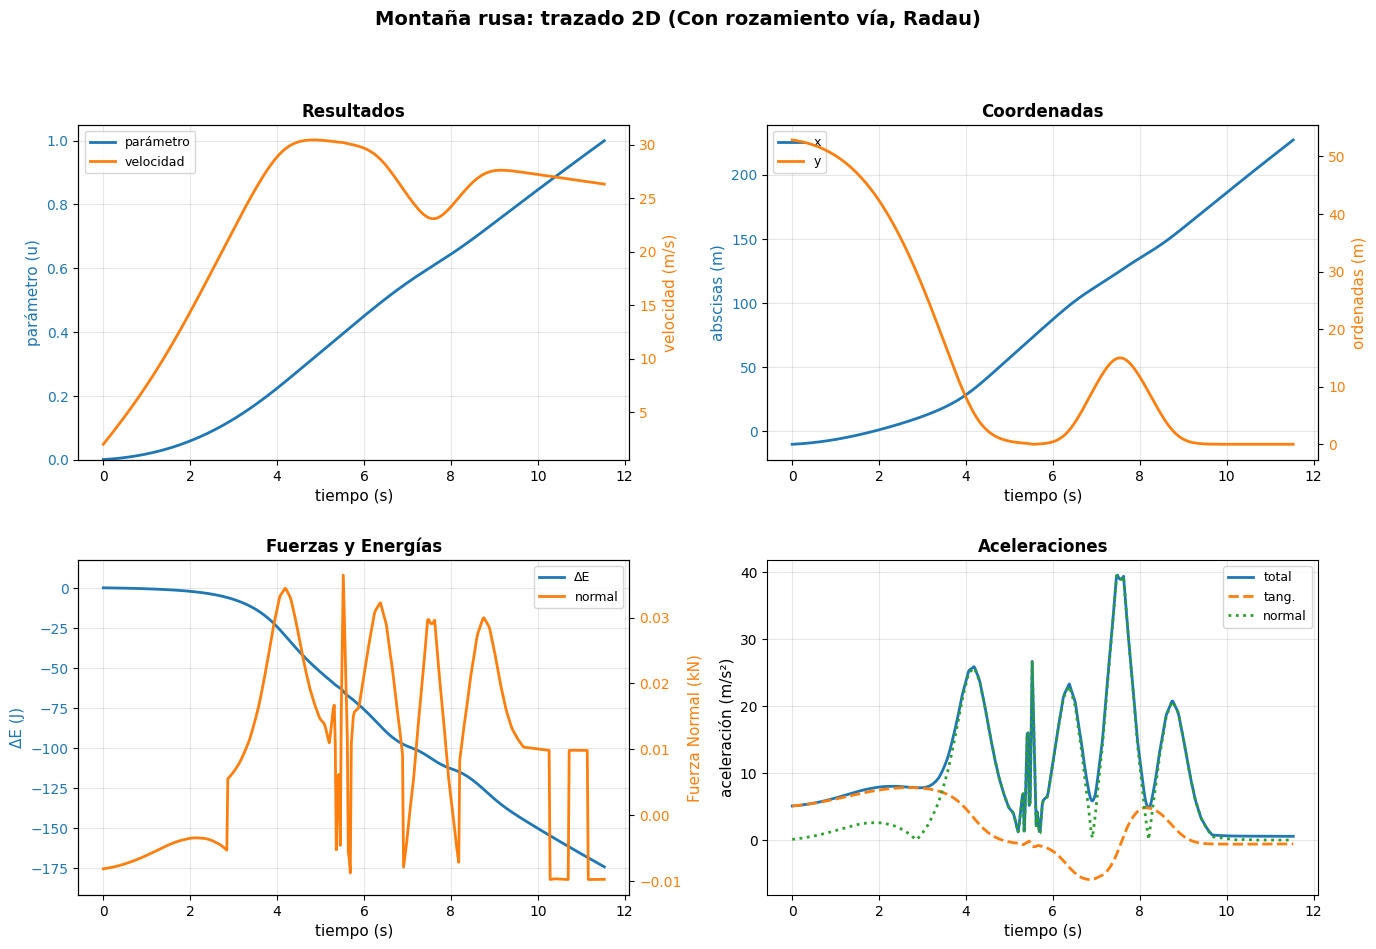


ESTADÍSTICAS DEL RECORRIDO
Tiempo total:           11.53 s
Velocidad máxima:       30.44 m/s (109.58 km/h)
Velocidad media:        23.04 m/s (82.96 km/h)
Aceleración máxima:     39.51 m/s² (4.03 g)
Fuerza normal máxima:   36.45 N/kg (3.72 g)
Energía inicial:        520.44 J/kg
Energía final:          346.17 J/kg
Pérdida de energía:     33.48 %


In [102]:
# -*- coding: utf-8 -*-
# ============================================================================
# PARÁMETROS DEL PROBLEMA
# ============================================================================

# Parámetros físicos
# Parámetros físicos dados
g = 9.81              # Aceleración gravitatoria (m/s²)
mu = 0.015            # Coeficiente de fricción
ca = 0.4              # Coeficiente de resistencia aerodinámica
Sf = 2.0              # Superficie frontal (m²)
rho_aire = 1.225      # Densidad del aire (kg/m³)
v0 = 2.0              # Velocidad inicial (m/s)
masa = 800.0          # Masa del vagón (kg)

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

# Condiciones iniciales
y0 = [0.0, 2.0]   # [u(0), v(0)] = [posición inicial, velocidad inicial]

t_end = 40.0

# Parámetros del solver
metodo = 'Radau'   # Método numérico: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
rtol = 1e-6       # Tolerancia relativa
atol = 1e-9       # Tolerancia absoluta

# ============================================================================
# RESOLVER LA EDO
# ============================================================================

print(f"\nResolviendo con método {metodo}...")

sol = solve_ivp(
    edofun_mr_wrapper,
    t_span=(0.0, t_end),
    y0=y0,
    args=(derivs, coefRoz, coefVis, g),
    method=metodo,
    events=[finalVia_wrapper, paradaVagon_wrapper],
    dense_output=True,  # Necesario para interpolación
    rtol=rtol,
    atol=atol
)

# Verificar si la solución fue exitosa
if not sol.success:
    raise RuntimeError(f"El solver falló: {sol.message}")

print(f"✓ Solución obtenida exitosamente")
print(f"  Número de pasos: {len(sol.t)}")
print(f"  Tiempo final: {sol.t[-1]:.2f} s")
print(f"  Posición final: u = {sol.y[0][-1]:.4f}")
print(f"  Velocidad final: v = {sol.y[1][-1]:.2f} m/s")

# Verificar eventos
if sol.t_events[0].size > 0:
    print(f"  ✓ Evento 'finalVia' activado en t = {sol.t_events[0][0]:.2f} s")
if sol.t_events[1].size > 0:
    print(f"  ⚠ Evento 'paradaVagon' activado en t = {sol.t_events[1][0]:.2f} s")

# ============================================================================
# PREPARAR DATOS PARA GRAFICADO
# ============================================================================

# Parámetros para los gráficos
n_puntos = 500  # Número de puntos para suavizar las curvas

titulo = f"Montaña rusa: trazado 2D (Con rozamiento vía, {metodo})"

# ============================================================================
# CALCULAR DATOS PARA LOS GRÁFICOS
# ============================================================================

# Generar puntos de tiempo uniformes
time = np.linspace(0, sol.t[-1], n_puntos)

# Obtener solución interpolada (requiere dense_output=True en solve_ivp)
data = sol.sol(time)
u = data[0]  # parámetro
v = data[1]  # velocidad

# Calcular posición espacial
posicion = curva_bspline(u)

# Verificar la forma del array y extraer correctamente
print(f"\nForma de posicion: {posicion.shape}")

# Extraer coordenadas correctamente según la forma del array
if posicion.ndim == 1:
    # Si es un array 1D (un solo punto), replicar
    x = np.full(n_puntos, posicion[0])
    y = np.full(n_puntos, posicion[2])
elif posicion.shape[0] == 3:
    # Forma (3, n_puntos) - LO MÁS COMÚN
    x = posicion[0, :]  # primera fila = coordenada x
    y = posicion[2, :]  # tercera fila = coordenada z (altura)
elif posicion.shape[1] == 3:
    # Forma (n_puntos, 3) - alternativa
    x = posicion[:, 0]
    y = posicion[:, 2]
else:
    raise ValueError(f"Forma de posicion no esperada: {posicion.shape}")

print(f"Forma de x: {x.shape}, Forma de y: {y.shape}")
print(f"Forma de time: {time.shape}, Forma de u: {u.shape}, Forma de v: {v.shape}")

# Inicializar arrays para fuerzas, energías y aceleraciones
E_total = np.zeros(n_puntos)
F_normal = np.zeros(n_puntos)
a_total = np.zeros(n_puntos)
a_tang = np.zeros(n_puntos)
a_normal = np.zeros(n_puntos)

# Calcular para cada punto
print("Calculando fuerzas, energías y aceleraciones...")
for i in range(n_puntos):
    try:
        # Energía total por unidad de masa
        E_total[i] = energia(u[i], v[i], derivs[0], grav=g)
        
        # Fuerza normal por unidad de masa
        fuerzaN, baseLocal, ctes = fuerzaNormal(u[i], v[i], derivs, grav=g)
        F_normal[i] = fuerzaN
        
        # Aceleraciones
        a_tot, a_tg, a_nr = aceleracion(v[i], baseLocal, coefRoz, coefVis, 
                                         fuerzaN, ctes[1], grav=g)
        a_total[i] = a_tot
        a_tang[i] = a_tg
        a_normal[i] = a_nr
    except Exception as e:
        print(f"Error en punto {i}: {e}")
        # Usar valores del punto anterior o cero
        if i > 0:
            E_total[i] = E_total[i-1]
            F_normal[i] = F_normal[i-1]
            a_total[i] = a_total[i-1]
            a_tang[i] = a_tang[i-1]
            a_normal[i] = a_normal[i-1]

print("✓ Cálculos completados")

# ============================================================================
# CREAR FIGURA CON 4 SUBPLOTS
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ============================================================================
# SUBPLOT 1: RESULTADOS (parámetro u y velocidad v vs tiempo)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

# Eje izquierdo: parámetro u
color_u = 'tab:blue'
ax1.set_xlabel('tiempo (s)', fontsize=11)
ax1.set_ylabel('parámetro (u)', color=color_u, fontsize=11)
line1 = ax1.plot(time, u, color=color_u, linewidth=2, label='parámetro')
ax1.tick_params(axis='y', labelcolor=color_u)
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Eje derecho: velocidad v
ax1_twin = ax1.twinx()
color_v = 'tab:orange'
ax1_twin.set_ylabel('velocidad (m/s)', color=color_v, fontsize=11)
line2 = ax1_twin.plot(time, v, color=color_v, linewidth=2, label='velocidad')
ax1_twin.tick_params(axis='y', labelcolor=color_v)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', fontsize=9)

ax1.set_title('Resultados', fontsize=12, fontweight='bold')

# ============================================================================
# SUBPLOT 2: COORDENADAS (x e y vs tiempo)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])

# Eje izquierdo: abscisas x
color_x = 'tab:blue'
ax2.set_xlabel('tiempo (s)', fontsize=11)
ax2.set_ylabel('abscisas (m)', color=color_x, fontsize=11)
line1 = ax2.plot(time, x, color=color_x, linewidth=2, label='x')
ax2.tick_params(axis='y', labelcolor=color_x)
ax2.grid(True, alpha=0.3)

# Eje derecho: ordenadas y
ax2_twin = ax2.twinx()
color_y = 'tab:orange'
ax2_twin.set_ylabel('ordenadas (m)', color=color_y, fontsize=11)
line2 = ax2_twin.plot(time, y, color=color_y, linewidth=2, label='y')
ax2_twin.tick_params(axis='y', labelcolor=color_y)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best', fontsize=9)

ax2.set_title('Coordenadas', fontsize=12, fontweight='bold')

# ============================================================================
# SUBPLOT 3: FUERZAS Y ENERGÍAS (mostrando pérdida de energía)
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])

# --- Energía: mostrar variación respecto al inicio en Joules ---
E0_kJ = E_total[0] / 1000.0                # energía inicial (kJ)
dE_J  = (E_total / 1000.0 - E0_kJ) * 1000  # ΔE en Joules (porque 1 kJ = 1000 J)

color_E = 'tab:blue'
ax3.set_xlabel('tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J)', color=color_E, fontsize=11)
line1 = ax3.plot(time, dE_J, color=color_E, linewidth=2, label='ΔE')
ax3.tick_params(axis='y', labelcolor=color_E)
ax3.grid(True, alpha=0.3)

# --- Escala: ajusta automáticamente con margen para que se aprecie la pérdida ---
dE_min = float(min(dE_J))
dE_max = float(max(dE_J))
span = dE_max - dE_min
if span == 0:
    span = 1.0  # evita división por cero si fuera constante

margin = 0.10 * span  # 10% de margen
ax3.set_ylim(dE_min - margin, dE_max + margin)

# --- Fuerza normal en el eje derecho (kN) ---
ax3_twin = ax3.twinx()
color_F = 'tab:orange'
ax3_twin.set_ylabel('Fuerza Normal (kN)', color=color_F, fontsize=11)
line2 = ax3_twin.plot(time, F_normal/1000.0, color=color_F, linewidth=2, label='normal')
ax3_twin.tick_params(axis='y', labelcolor=color_F)

# --- Leyenda combinada ---
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='best', fontsize=9)

ax3.set_title('Fuerzas y Energías', fontsize=12, fontweight='bold')


# ============================================================================
# SUBPLOT 4: ACELERACIONES
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])

ax4.set_xlabel('tiempo (s)', fontsize=11)
ax4.set_ylabel('aceleración (m/s²)', fontsize=11)

ax4.plot(time, a_total, linewidth=2, label='total', color='tab:blue')
ax4.plot(time, a_tang, linewidth=2, linestyle='--', label='tang.', 
         color='tab:orange')
ax4.plot(time, a_normal, linewidth=2, linestyle=':', label='normal', 
         color='tab:green')

ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)
ax4.set_title('Aceleraciones', fontsize=12, fontweight='bold')

# ============================================================================
# TÍTULO GENERAL Y MOSTRAR
# ============================================================================
fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# ============================================================================
# ESTADÍSTICAS ADICIONALES (OPCIONAL)
# ============================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS DEL RECORRIDO")
print("="*70)
print(f"Tiempo total:           {sol.t[-1]:.2f} s")
print(f"Velocidad máxima:       {np.max(v):.2f} m/s ({np.max(v)*3.6:.2f} km/h)")
print(f"Velocidad media:        {np.mean(v):.2f} m/s ({np.mean(v)*3.6:.2f} km/h)")
print(f"Aceleración máxima:     {np.max(a_total):.2f} m/s² ({np.max(a_total)/g:.2f} g)")
print(f"Fuerza normal máxima:   {np.max(F_normal):.2f} N/kg ({np.max(F_normal)/g:.2f} g)")
print(f"Energía inicial:        {E_total[0]:.2f} J/kg")
print(f"Energía final:          {E_total[-1]:.2f} J/kg")

if coefRoz > 0 or coefVis > 0:
    perdida = (E_total[0] - E_total[-1]) / E_total[0] * 100
    print(f"Pérdida de energía:     {perdida:.2f} %")
else:
    # Sistema conservativo - verificar conservación
    dE = np.abs(E_total - E_total[0]) / E_total[0]
    conservacion = np.max(dE) * 100
    print(f"Máx variación energía:  {conservacion:.4f} % (conservativo)")

print("="*70)